Running Your Queries In Spark
---------------------------

You need to take the data from Twitter and perform your analysis based on the question you chose.

In our hashtag counting example, we do the following:
1. Explode the tweet into its individual words.
2. Filter out hashtags, then each tag gets assigned the count 1 with the `map` method.
3. Append the current hashtags to the main dataframe and update the counts appropriately.
4. Query the temporary table to return the current top 10 hashtags trending, and show to the console.

You can extend this into a web dashboard, or plots inside this notebook if you choose.

----------------------------------------------------------------------------------------------------------------------

#### Import the relevant modules

In [50]:
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row,SQLContext, SparkSession
import sys
import requests
import matplotlib.pyplot as plt
%matplotlib inline

#### Set some constants, initialize Spark, and then open the socket with the remote host.

In [107]:
TCP_REMOTE_HOST = "data_server"
TCP_PORT = 9009

# create spark configuration
conf = SparkConf()
conf.setAppName("TwitterStreamApp")

# create spark context with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")

# create the Streaming Context from the above spark context with interval size 2 seconds
ssc = StreamingContext(sc, 2)

# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")

# read data from port 9009
dataStream = ssc.socketTextStream(TCP_REMOTE_HOST, TCP_PORT)

#### We now create some helper functions to allow Spark to maintain our running count.

In [106]:
def aggregate_tags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

def getSparkSessionInstance(sparkConf):
    if ("sparkSessionSingletonInstance" not in globals()):
        globals()["sparkSessionSingletonInstance"] = SparkSession \
            .builder \
            .config(conf=sparkConf) \
            .getOrCreate()
    return globals()["sparkSessionSingletonInstance"]

def process_rdd(time, rdd):
    print(f"----------- {str(time)} -----------")
    try:
        # Get spark sql singleton context from the current context
        spark = getSparkSessionInstance(rdd.context.getConf())
        
        # convert the RDD to Row RDD
        row_rdd = rdd.map(lambda w: Row(hashtag=w[0], hashtag_count=w[1]))
        
        # create a DF from the Row RDD
        hashtags_df = spark.createDataFrame(row_rdd)
        
        # Register the dataframe as table
        hashtags_df.registerTempTable("hashtags")
        #hashtags_df.createOrReplaceTempView("hashtags")
        
        # get the top 10 hashtags from the table using SQL and print them
        hashtag_counts_df = spark.sql(
            "select hashtag, hashtag_count from hashtags order by hashtag_count desc limit 10")
        hashtag_counts_df.show()

    except Exception as e:
        e = sys.exc_info()[1]
        print(f"Error: {e}")

#### Finally, we assign our primary workflow that will utilize the above functions.

After that's complete, we begin the streaming with `ssc.start()`. The query stays open until we terminate it (`ssc.awaitTermination()`).

We can end the streaming by going to the `data_server` container and typing `ctrl-C`. Recall that you can exit the container shell with the `Ctrl-P, Ctrl-Q` sequence.

If you are using tweets from a geofenced area (as we are here) - you should let it run for a while in order to build up enough data to be useful.

In [4]:
# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)

# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

----------- 2018-07-16 22:45:58 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:00 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:02 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:04 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:06 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:08 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:10 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:12 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:14 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:16 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:18 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:20 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:22 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:24 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:26 -----------
Error: RDD is empty
----------- 2018-07-16 22:46:28 --------

+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|#saltwatergospel@...|            1|
+--------------------+-------------+

----------- 2018-07-16 22:47:30 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|#saltwatergospel@...|            1|
+--------------------+-------------+

----------- 2018-07-16 22:47:32 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|#saltwatergospel@...|            1|
+--------------------+-------------+

----------- 2018-07-16 22:47:34 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|#saltwatergospel@...|            1|
+-------------

----------- 2018-07-16 22:48:30 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|#saltwatergospel@...|            1|
+--------------------+-------------+

----------- 2018-07-16 22:48:32 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut|            1|
+--------------------+-------------+

----------- 2018-07-16 22:48:34 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #cat

+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut|            1|
+--------------------+-------------+

----------- 2018-07-16 22:49:12 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut|            1|
+--------------------+-------------+

----------- 2018-07-16 22:49:14 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|

----------- 2018-07-16 22:49:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|       #TrumpTreason|            1|
|      #PutinsPuppeta|            1|
|           #nofilter|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut|            1|
+--------------------+-------------+

----------- 2018-07-16 22:49:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|       #TrumpTreason|            1|
|      #PutinsPuppeta|            1|
|           #nofilter|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut| 

----------- 2018-07-16 22:50:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|       #TrumpTreason|            1|
|      #PutinsPuppeta|            1|
|           #nofilter|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut|            1|
+--------------------+-------------+

----------- 2018-07-16 22:50:20 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #newavi|            1|
|       #ififitsisits|            1|
|       #TrumpTreason|            1|
|      #PutinsPuppeta|            1|
|           #nofilter|            1|
|#saltwatergospel@...|            1|
|   #spoiledrottenmoo|            1|
|          #catinabox|            1|
|          #Austinaut| 

----------- 2018-07-16 22:50:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|       #moparnation|            1|
+-------------------+-------------+

----------- 2018-07-16 22:50:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#mop

----------- 2018-07-16 22:51:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|       #moparnation|            1|
+-------------------+-------------+

----------- 2018-07-16 22:51:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#mop

----------- 2018-07-16 22:51:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|       #moparnation|            1|
+-------------------+-------------+

----------- 2018-07-16 22:51:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            2|
|            #newavi|            1|
|     #PutinsPuppeta|            1|
|      #ififitsisits|            1|
|           #ADE2018|            1|
|          #nofilter|            1|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|    /:#mop

----------- 2018-07-16 22:52:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|          #nofilter|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|           #ADE2018|            1|
|    /:#moparornocar|            1|
+-------------------+-------------+

----------- 2018-07-16 22:52:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|          #nofilter|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|          

----------- 2018-07-16 22:52:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|          #nofilter|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|           #ADE2018|            1|
|    /:#moparornocar|            1|
+-------------------+-------------+

----------- 2018-07-16 22:52:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|          #nofilter|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|          

----------- 2018-07-16 22:53:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|    /:#moparornocar|            1|
|          #nofilter|            1|
|  #EveroneCanCreate|            1|
+-------------------+-------------+

----------- 2018-07-16 22:53:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|            #newavi|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
|#photographyislife…|            1|
|    /:#moparornocar|            1|
|          

----------- 2018-07-16 22:53:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            2|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
| #photographylovers|            2|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|    /:#moparornocar|            1|
|          #nofilter|            1|
+-------------------+-------------+

----------- 2018-07-16 22:53:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            2|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
| #photographylovers|            2|
|#photographyislife…|            1|
|  #EveroneCanCreate|            1|
|     #PutinsPuppeta|            1|
|    /:#mop

----------- 2018-07-16 22:54:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:54:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ifi

----------- 2018-07-16 22:54:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:54:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ifi

----------- 2018-07-16 22:55:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:55:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ifi

----------- 2018-07-16 22:55:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:55:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ifi

----------- 2018-07-16 22:56:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:56:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|       #photography|            3|
|      #TrumpTreason|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|           #ADE2018|            2|
|#photographyislife…|            2|
|  #EveroneCanCreate|            1|
|    /:#moparornocar|            1|
|      #ifi

----------- 2018-07-16 22:56:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:56:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:57:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:57:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:57:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:57:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:58:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:58:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:58:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:58:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:59:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:59:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 22:59:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 22:59:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:00:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:00:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:00:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:00:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:01:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:01:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:01:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:01:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:02:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:02:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:02:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:02:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:03:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:03:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:03:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:03:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:04:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:04:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:04:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:04:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:05:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:05:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:05:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:05:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:06:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:06:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:06:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:06:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:07:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:07:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:07:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:07:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:08:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:08:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:08:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:08:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:09:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:09:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:09:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:09:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:10:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:10:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:10:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:10:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:11:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:11:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:11:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:11:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:12:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:12:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:12:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:12:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:13:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:13:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:13:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:13:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:14:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:14:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:14:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:14:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:15:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:15:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:15:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:15:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:16:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:16:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:16:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:16:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:17:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:17:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:17:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:17:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:18:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:18:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:18:50 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:18:52 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:19:20 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:19:22 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

KeyboardInterrupt: 

----------- 2018-07-16 23:19:30 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:19:32 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:20:00 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:20:02 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:20:30 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:20:32 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:21:00 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:21:02 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:21:30 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:21:32 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

----------- 2018-07-16 23:22:00 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+

----------- 2018-07-16 23:22:02 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ifi

In [5]:
ssc.stop()
# this is what the Austin area was talking about between 5:46pm and 6:22pm 

+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|      #TrumpTreason|            3|
|       #photography|            3|
|           #ADE2018|            3|
| #photographylovers|            3|
|      #PutinsPuppet|            2|
|#photographyislife…|            2|
|           #Austin,|            2|
|               #job|            2|
|      #ififitsisits|            1|
|     #PutinsPuppeta|            1|
+-------------------+-------------+



I changed server.py to not track hash symbol, only do location tweets. lets see what Austin is talking about now.

In [14]:
# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)

# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

----------- 2018-07-17 01:08:02 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:04 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:06 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:08 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:10 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:12 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:14 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:16 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:18 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:20 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:22 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:24 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:26 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:28 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:30 -----------
Error: RDD is empty
----------- 2018-07-17 01:08:32 --------

+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

----------- 2018-07-17 01:09:28 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

--

----------- 2018-07-17 01:09:58 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

----------- 2018-07-17 01:10:00 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|        

----------- 2018-07-17 01:10:30 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

----------- 2018-07-17 01:10:32 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|        

----------- 2018-07-17 01:11:02 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

----------- 2018-07-17 01:11:04 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|        

----------- 2018-07-17 01:11:34 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|            1|
+-----------------+-------------+

----------- 2018-07-17 01:11:36 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#AllStarGameBLAKE|            1|
| #Worthless“Free,|            1|
|      #TeenMom2My|            1|
|           #Score|            1|
|        #Helsinki|            1|
|         #theyard|            1|
|            #satx|            1|
|           #Putin|            1|
|              #SA|            1|
|   #6manfbchatHey|        

----------- 2018-07-17 01:12:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:12:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:12:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:12:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:13:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:13:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:13:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:13:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:14:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:14:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:14:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:14:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:15:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:15:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:15:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:15:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:16:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:16:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:16:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
|#TrumpIsNotAboveT...|            1|
+--------------------+-------------+

----------- 2018-07-17 01:16:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #AllStarGameBLAKE|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin| 

----------- 2018-07-17 01:17:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:17:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:17:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:17:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:18:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:18:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            2|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:18:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:18:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:19:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:19:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:19:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:19:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:20:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:20:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:20:36 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:20:38 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:21:06 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx|            1|
|              #Putin|            1|
|    #TreasonousTrump|            1|
+--------------------+-------------+

----------- 2018-07-17 01:21:08 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|    #IMPEACHTRUMPNOW|            3|
|#TrumpIsNotAboveT...|            1|
|    #Worthless“Free,|            1|
|         #TeenMom2My|            1|
|              #Score|            1|
|           #Helsinki|            1|
|            #theyard|            1|
|               #satx| 

----------- 2018-07-17 01:21:36 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:21:38 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:22:10 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:22:12 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:22:44 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:22:46 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:23:18 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:23:20 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:23:52 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:23:54 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:24:26 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:24:28 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:25:00 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:25:02 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:25:34 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:25:36 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:26:08 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:26:10 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
|             #IB|            2|
|     #wyeslearns|            2|
|     #NephewLove|            2|
| #summerisPDtime|            2|
|     #BentonKirk|            2|
|          #Score|            1|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:26:42 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|           #kstn|            3|
|             #IB|            3|
|     #wyeslearns|            2|
|     #NephewLove|            2|
|     #BentonKirk|            2|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:26:44 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|           #kstn|            3|
|             #IB|            3|
|     #wyeslearns|            2|
|     #NephewLove|            2|
|     #BentonKirk|            2|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:27:16 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|           #kstn|            3|
|             #IB|            3|
|     #wyeslearns|            2|
|     #NephewLove|            2|
|     #BentonKirk|            2|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:27:18 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|           #kstn|            3|
|             #IB|            3|
|     #wyeslearns|            2|
|     #NephewLove|            2|
|     #BentonKirk|            2|
|#Worthless“Free,|            1|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:27:50 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:27:52 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:28:24 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:28:26 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

----------- 2018-07-17 01:28:58 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:29:00 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+--

KeyboardInterrupt: 

+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:29:20 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+

----------- 2018-07-17 01:29:2

In [15]:
ssc.stop()

----------- 2018-07-17 01:29:24 -----------
+----------------+-------------+
|         hashtag|hashtag_count|
+----------------+-------------+
|           #kstn|            3|
|#IMPEACHTRUMPNOW|            3|
| #summerisPDtime|            3|
|             #IB|            3|
|         #Austin|            2|
|     #wyeslearns|            2|
|     #BentonKirk|            2|
|     #NephewLove|            2|
|       #Helsinki|            1|
|        #theyard|            1|
+----------------+-------------+



I let that run from 8:08pm till 8:28pm. 

In [19]:
# lets see what chicago is talking about today.
# running the stream again after changing the coordinates
# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)

# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

----------- 2018-07-17 17:05:54 -----------
Error: RDD is empty
----------- 2018-07-17 17:05:56 -----------
Error: RDD is empty
----------- 2018-07-17 17:05:58 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:00 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:02 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:04 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:06 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:08 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:10 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:12 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:14 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:16 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:18 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:20 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:22 -----------
Error: RDD is empty
----------- 2018-07-17 17:06:24 --------

----------- 2018-07-17 17:07:04 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|          #progress|            1|
|       #106andClark|            1|
|  #TreasonSummitDay|            1|
|#infosyspathfinders|            1|
|           #tatting|            1|
|       #tattinglace|            1|
+-------------------+-------------+

----------- 2018-07-17 17:07:06 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|          #progress|            1|
|       #106andClark|            1|
|  #TreasonSummitDay|            1|
|#infosyspathfinders|            1|
|           #tatting|            1|
|       #tattinglace|            1|
+-------------------+-------------+

----------- 2018-07-17 17:07:08 -----------
+-------------------+-------------+
|            hashtag|hashtag_count|
+-------------------+-------------+
|          #progress|            1|
| 

----------- 2018-07-17 17:07:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            2|
|   #TreasonSummitDay|            1|
|        #106andClark|            1|
|married?#NewWorkA...|            1|
|           #Chicago,|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|     #Cubs@lacurtis_|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:07:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            2|
|   #TreasonSummitDay|            1|
|        #106andClark|            1|
|married?#NewWorkA...|            1|
|           #Chicago,|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018| 

----------- 2018-07-17 17:08:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:08:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:08:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:08:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:09:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:09:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:09:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:09:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:10:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:10:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:10:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago|            1|
|            #ASG2018|            1|
|             #Hiring|            1|
+--------------------+-------------+

----------- 2018-07-17 17:10:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|           #progress|            2|
|                #job|            2|
|       #spoileralert|            1|
|           #Chicago,|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
|            #Chicago| 

----------- 2018-07-17 17:11:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,|            1|
|            #Chicago|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:11:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,| 

----------- 2018-07-17 17:11:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,|            1|
|            #Chicago|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:11:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,| 

----------- 2018-07-17 17:12:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,|            1|
|            #Chicago|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:12:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            4|
|           #progress|            2|
|             #Hiring|            2|
|       #spoileralert|            1|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|           #Chicago,| 

----------- 2018-07-17 17:12:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|           #Chicago,|            2|
|             #Hiring|            2|
|   #CREDITREPAIRGOD…|            2|
|           #progress|            2|
|            #Chicago|            1|
|            #ASG2018|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
|#Hiring@donna_bummer|            1|
+--------------------+-------------+

----------- 2018-07-17 17:12:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|           #Chicago,|            2|
|             #Hiring|            2|
|   #CREDITREPAIRGOD…|            2|
|           #progress|            2|
|            #Chicago|            1|
|            #ASG2018|            1|
|married?#NewWorkA...| 

----------- 2018-07-17 17:13:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            2|
|            #Chicago|            2|
|           #progress|            2|
|             #Hiring|            2|
|           #Chicago,|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:13:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            2|
|            #Chicago|            2|
|           #progress|            2|
|             #Hiring|            2|
|           #Chicago,|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018| 

----------- 2018-07-17 17:13:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #Chicago,|            2|
|           #progress|            2|
|            #Chicago|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:13:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #Chicago,|            2|
|           #progress|            2|
|            #Chicago|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018| 

----------- 2018-07-17 17:14:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #Chicago,|            2|
|           #progress|            2|
|            #Chicago|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
|married?#NewWorkA...|            1|
|     #Cubs@lacurtis_|            1|
+--------------------+-------------+

----------- 2018-07-17 17:14:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #Chicago,|            2|
|           #progress|            2|
|            #Chicago|            2|
|#Hiring@donna_bummer|            1|
|            #ASG2018| 

----------- 2018-07-17 17:14:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|           #progress|            2|
|             #Hiring|            2|
|      #WorldEmojiDay|            2|
|           #Chicago,|            2|
|            #Chicago|            2|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
|            #ASG2018|            1|
+--------------------+-------------+

----------- 2018-07-17 17:14:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|           #progress|            2|
|             #Hiring|            2|
|      #WorldEmojiDay|            2|
|           #Chicago,|            2|
|            #Chicago|            2|
|married?#NewWorkA...| 

----------- 2018-07-17 17:15:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,|            2|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
+--------------------+-------------+

----------- 2018-07-17 17:15:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,| 

----------- 2018-07-17 17:15:46 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,|            2|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
+--------------------+-------------+

----------- 2018-07-17 17:15:48 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,| 

----------- 2018-07-17 17:16:16 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,|            2|
|married?#NewWorkA...|            1|
|#Hiring@donna_bummer|            1|
+--------------------+-------------+

----------- 2018-07-17 17:16:18 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|      #WorldEmojiDay|            5|
|                #job|            5|
|   #CREDITREPAIRGOD…|            3|
|             #Hiring|            2|
|           #progress|            2|
|            #Chicago|            2|
|      #worldemojiday|            2|
|           #Chicago,| 

----------- 2018-07-17 17:16:48 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            6|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|            #Jobs|            2|
|             #Job|            2|
|         #Chicago|            2|
|         #hiring!|            2|
|   #worldemojiday|            2|
+-----------------+-------------+

----------- 2018-07-17 17:16:50 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            6|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|            #Jobs|            2|
|             #Job|            2|
|         #Chicago|            2|
|         #hiring!|            2|
|   #worldemojiday|        

----------- 2018-07-17 17:17:20 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|            #Jobs|            2|
|             #Job|            2|
|         #Chicago|            2|
|   #worldemojiday|            2|
+-----------------+-------------+

----------- 2018-07-17 17:17:22 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|            #Jobs|            2|
|             #Job|            2|
|         #Chicago|            2|
|   #worldemojiday|        

----------- 2018-07-17 17:17:52 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:17:54 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|        

----------- 2018-07-17 17:18:24 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:18:26 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|        

----------- 2018-07-17 17:18:56 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|            7|
|   #WorldEmojiDay|            5|
|        #Chicago,|            4|
|#CREDITREPAIRGOD…|            3|
|          #Hiring|            3|
|         #hiring!|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:18:58 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           11|
|   #WorldEmojiDay|            5|
|          #Hiring|            5|
|        #Chicago,|            5|
|         #hiring!|            4|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|        

----------- 2018-07-17 17:19:28 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           11|
|   #WorldEmojiDay|            5|
|          #Hiring|            5|
|        #Chicago,|            5|
|         #hiring!|            4|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:19:30 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           11|
|   #WorldEmojiDay|            5|
|          #Hiring|            5|
|        #Chicago,|            5|
|         #hiring!|            4|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|         #Chicago|            2|
|             #Job|        

----------- 2018-07-17 17:20:00 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           12|
|          #Hiring|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:20:02 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           12|
|          #Hiring|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:20:32 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           12|
|          #Hiring|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:20:34 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           12|
|          #Hiring|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:21:04 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           13|
|          #Hiring|            7|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:21:06 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           13|
|          #Hiring|            7|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:21:36 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           14|
|          #Hiring|            8|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:21:38 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           14|
|          #Hiring|            8|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:22:08 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:22:10 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:22:40 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:22:42 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:23:12 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:23:14 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:23:44 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:23:46 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:24:16 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:24:18 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           15|
|          #Hiring|            9|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:24:48 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:24:50 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|        #Chicago,|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

----------- 2018-07-17 17:25:20 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|        #Chicago,|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:25:22 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|        #Chicago,|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

KeyboardInterrupt: 

----------- 2018-07-17 17:25:46 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|        #Chicago,|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+

----------- 2018-07-17 17:25:48 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|        #Chicago,|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|        

This ran from 12:06 pm till 12:25, capturing tweets in Chicago.

In [20]:
ssc.stop()

+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|             #job|           16|
|          #Hiring|           10|
|        #Chicago,|            6|
|   #WorldEmojiDay|            5|
|         #hiring!|            5|
|         #Chicago|            3|
|#CREDITREPAIRGOD…|            3|
|   #worldemojiday|            2|
|         #wedding|            2|
|             #Job|            2|
+-----------------+-------------+



Thinking out loud.  
I want to gather the incoming tweet location and plot them on a heatmap using gmplot. 


I want to change process_rdd so that I get the coordinates of incoming texts and plot them on a heatmap as they happen. 

i want to take the incoming coordiantes and feed them into a dataframe where lat and lon are separate columns and then i can feed each column into gmplot seperately and get a heatmap when i'm done collecting coords.

I am going to plot the captured data into a barchart with matplotlib library

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
#        plt.hist(hashtag_counts_df['hastag_count'], label=hashtag_counts_df['hashtag'])


----------- 2018-07-18 23:25:20 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:22 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:24 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:26 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:28 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:30 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:32 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:34 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:36 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:38 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:40 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:42 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:44 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:46 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:48 -----------
Error: RDD is empty
----------- 2018-07-18 23:25:50 --------

KeyboardInterrupt: 

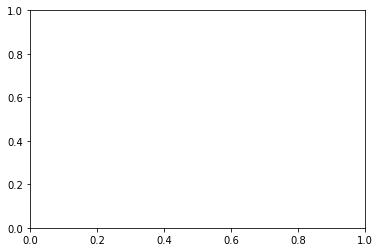

----------- 2018-07-18 23:26:38 -----------


In [78]:
# lets see what chicago is talking about today.
# running the stream again after changing the coordinates
# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)


# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

In [80]:
ssc.stop()

In [48]:
# lets see what Round Rock is talking about today.
# running the stream again after changing the coordinates

# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)


# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

----------- 2018-07-18 19:51:24 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:26 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:28 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:30 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:32 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:34 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:36 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:38 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:40 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:42 -----------
Error: RDD is empty
----------- 2018-07-18 19:51:44 -----------
Error: 'NoneType' object has no attribute 'setCallSite'
----------- 2018-07-18 19:51:46 -----------
Error: 'NoneType' object has no attribute 'setCallSite'
----------- 2018-07-18 19:51:48 -----------
Error: 'NoneType' object has no attribute 'setCallSite'
----------- 2018-07-18 19:51:50 -----------
Error: 'NoneType

KeyboardInterrupt: 

Error: 'NoneType' object has no attribute 'setCallSite'
----------- 2018-07-18 19:53:40 -----------
Error: 'NoneType' object has no attribute 'setCallSite'
----------- 2018-07-18 19:53:42 -----------
Error: 'NoneType' object has no attribute 'setCallSite'


In [49]:
ssc.stop()

----------- 2018-07-18 19:53:44 -----------
Error: 'NoneType' object has no attribute 'setCallSite'


In [108]:
# lets see what Round Rock is talking about today.
# running the stream again after changing the coordinates

# split each tweet into words
words = dataStream.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process_rdd)


# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()

#plt.hist(tags_totals)
#plt.show()


----------- 2018-07-19 02:34:48 -----------
Error: RDD is empty
----------- 2018-07-19 02:34:50 -----------
Error: RDD is empty
----------- 2018-07-19 02:34:52 -----------
Error: RDD is empty
----------- 2018-07-19 02:34:54 -----------
Error: RDD is empty
----------- 2018-07-19 02:34:56 -----------
Error: RDD is empty
----------- 2018-07-19 02:34:58 -----------
Error: RDD is empty
----------- 2018-07-19 02:35:00 -----------
Error: RDD is empty
----------- 2018-07-19 02:35:02 -----------
Error: RDD is empty
----------- 2018-07-19 02:35:04 -----------
Error: RDD is empty
----------- 2018-07-19 02:35:06 -----------


KeyboardInterrupt: 

Error: RDD is empty
----------- 2018-07-19 02:35:08 -----------


In [109]:
ssc.stop()

Error: RDD is empty
